# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

Abi Ehrlich, David Roddy, Manjari Agrawal

## General Setup

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

!pip install feature_engine
from feature_engine.creation import CyclicalFeatures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/project_2')

Mounted at /content/project_2


In [ ]:
# Load data
hotels = pd.read_csv("/content/project_2/MyDrive/Project_2/hotel.csv")

In [ ]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

For the details about data set;

- please check the Project Description pdf file and related article from the Learn page. 

## 1. Introduction

In this report we are going to use the data detailing the various features of the stays booked by different guests at the hotels to come up with a model that is able to prdict to a high level of accuracy whether a guest is going to cancel a booking or not. The details of the dataset and the variables we are working with can be seen below.

In [ ]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The first thing we will do is clean up the data and deal with all categorical variables. Since there are a few features with null values, we will deal with those in the next section. There are a number of categorical variables which we will encode mostly using One Hot Encoding. Most of the date variables will be dealt with by adding more features that give us a better undersanding of when in any year or any month the booking was made. This feature engineering will be followed by setting a variance threshold which will help us decide whether to keep a feature or not.

After this section we will choose a model that we will train on our reformed set of features. A logistic regression model, a classification tree model, a K neighbours classifier, a random forest classifier and an Ada bookst classifier will be trialed. One of these three models will then be used to predict to a certain level of accuracy whether a guest is going to cancel a reservation or not. We will conclude with an analysis of which of the features were particularly important in deciding whether a guest is going to cancel. 

## 2. Exploratory Data Analysis and Feature Engineering

In this section we will define some functions that we need to clean the data and construct new features. 

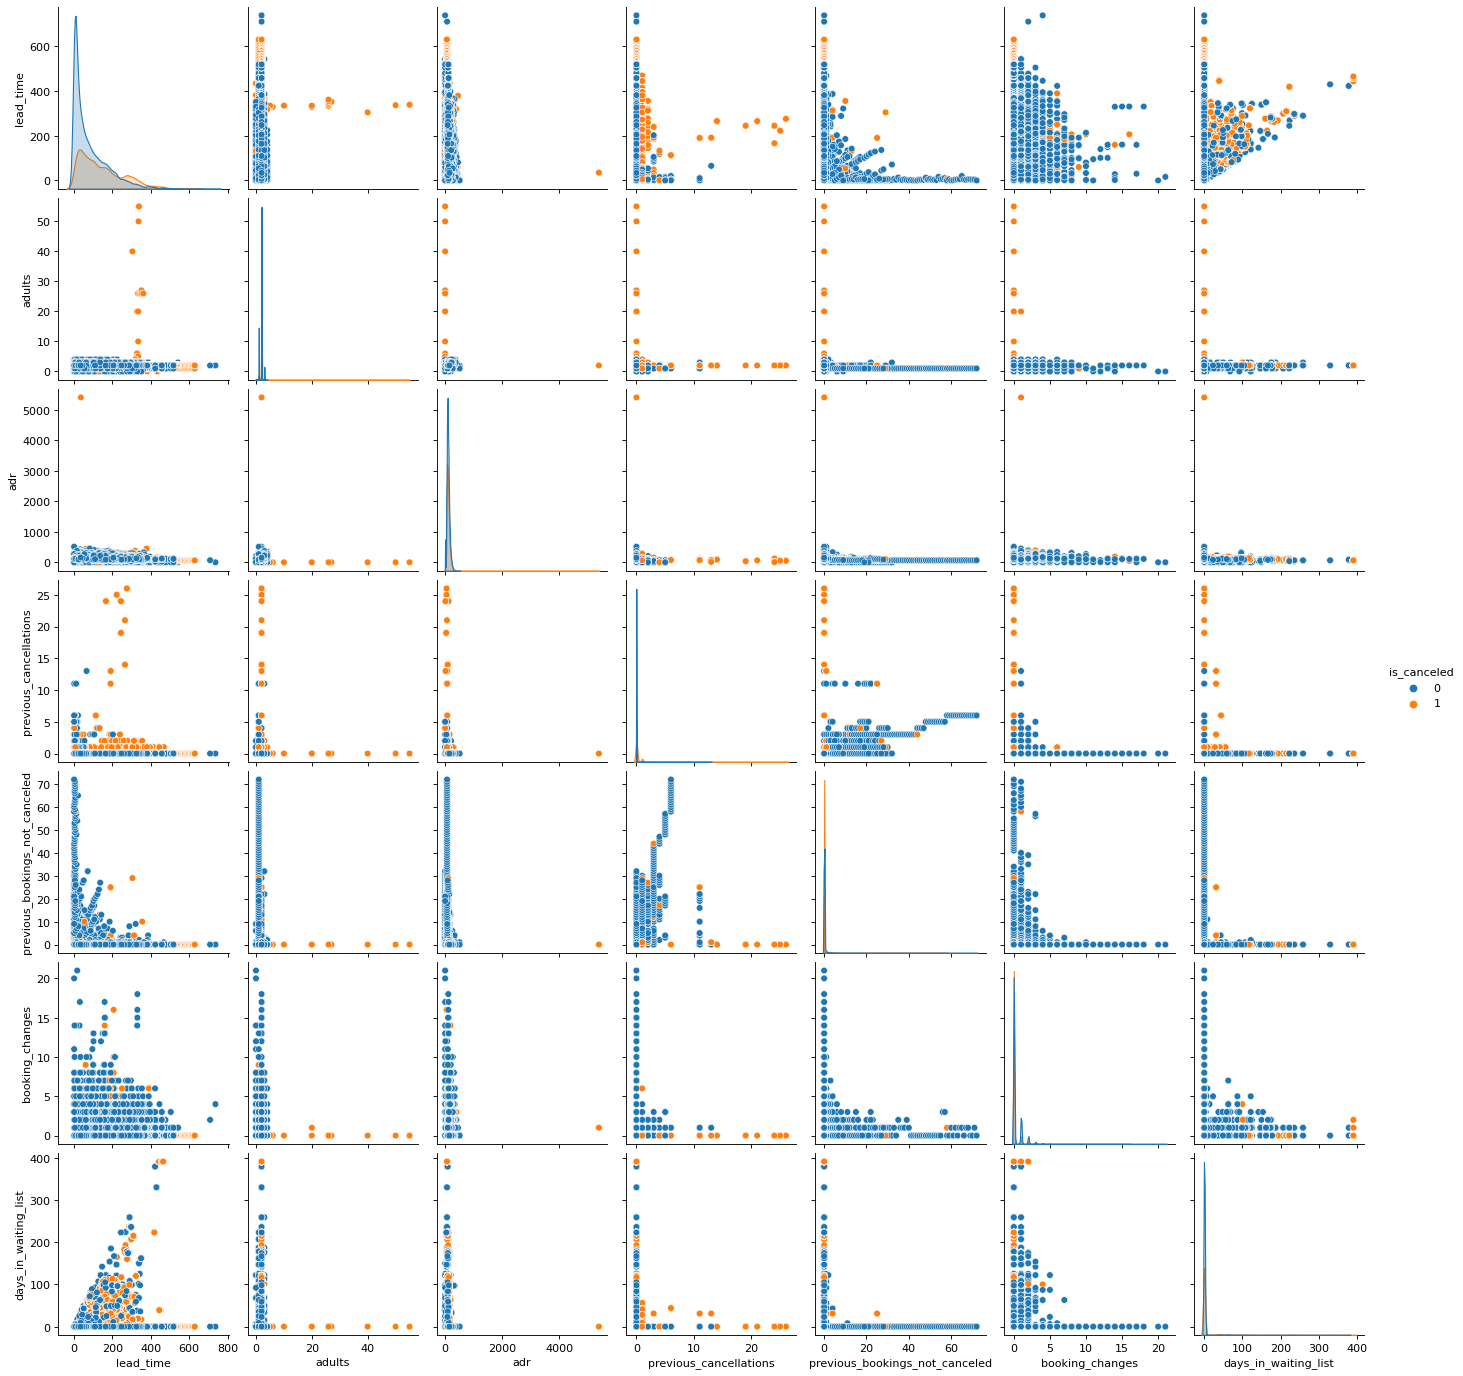

In [9]:
pp_vars=['lead_time', 'adults', 'adr', 'previous_cancellations', 
         'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list']
#sns.pairplot(hotels, vars=pp_vars, hue='is_canceled')

Looking at the above pairplot, we can see suggestions of a lot of correlation between variables but few of these indicate relationships with cancellation upon initial inspection. Firstly, `lead_time` and `days_in_waiting_list` show a strong positive correlation. Also, expectedly, `stays_in_weekend_nights` and `stays_in_week_nights` show a strong positive trend. Other important features of the plot are looking across the row for all `adults` plots, we can see all bookings for a number of adults greater than 10 are cancelled. Similarly, but perhaps more predictably, guests with high numbers of previous cancellations (ie 10 or more) nearly always cancel. These aren't necessarily things to single out before implementing the model as the chose model will account for this accordingly but it is maybe worth a hotel refusing bookings with more than 10 adults or from guests who have previously cancelled more than 10 times.

We define a function `remove_special_chars` below that replaces special characters with underscores in the data so that when we are encoding our categorical variables the output column names are easier to read.

In [ ]:
def remove_special_chars(df):
    df.columns = df.columns.str.replace(' ', '_')
    df = df.apply(lambda x: x.str.replace(' ', '_') if x.dtype == "object" else x)
    df = df.apply(lambda x: x.str.replace('/', '_') if x.dtype == "object" else x)
    df = df.apply(lambda x: x.str.replace('-', '_') if x.dtype == "object" else x)
    return df

We have 502 null values in total between the columns `children` and `country`. We use the code below to just remove these 502 rows in order to deal with the null values since the size of the data is not affected greatly. For columns `company` and `agent`, however, we set the N/A values to zero. This is because the values in this column are IDs so we will later be encoding this data and thus encoding the case where the booking doesn't have a company or agent.

In [ ]:
def fix_NAs(df):
    # get rid of entries with NA children or country
    df = df.dropna(subset=['children', 'country'])
    # turn NAs in company and agent to zeros
    df = df.fillna(value=0).reset_index(drop=True)
    return df

There is also some strange data entries in our set where there booking recorded has no weekend nights booked or week nights. Where these "bookings" have come from is unclear so due to the large amount of observations we can simply remove them.

In [ ]:
def strange_data(df):
    df = df[df['stays_in_weekend_nights'] + df['stays_in_week_nights'] != 0]
    return df

We remove the column `arrival_date_year` since knowing which year the guests arrived will not help us figure out if in a new year the guest is likely to cancel. Furthermore, in order to make the month and day of arrival within the month more informative we use `CyclicalFeatures`. It transforms the columns into sin and cos functions which tell us where in the year and month the arrival date was.

In [ ]:
def handle_time_month_day(df):
    # turn month names into numbers
    month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5,
                'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
                'November': 11, 'December': 12}
    df['arrival_date_month'] = df['arrival_date_month'].map(month_dict)

    # remove year
    df = df.drop(["arrival_date_year"], axis=1)

    # cyclic encoding of month and day
    cols_to_transform = ['arrival_date_day_of_month', 'arrival_date_month']
    cyclical = CyclicalFeatures(variables=cols_to_transform)
    df = cyclical.fit_transform(df)
    return df

We define a new column which tells us whether the reserved room was the sameas the room assigned to the guest. Secondly, we merge two categories within the `meal` column since they are essentially the same. Finally, we add another column that tells us the number of days the guests stayed in total.

In [ ]:
def rooms_meals_stay(df):
    # room changed
    df['was_room_changed'] = (df['assigned_room_type'] != df['reserved_room_type']).astype(int)

    # change undefined meals to SC
    df['meal'] = df['meal'].apply(lambda x: x.replace('Undefined', 'SC'))

    # add length of stay
    df["length_of_stay"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

    return df

Now, we encode every categorical data below using `OneHotEncoder` from `preprocessing`. We are basically making a new column for each category within each of the categorical variables. As these encoded variables are created, we can check the variance of each one and remove those that do not meet a variance threshold 'a'. We have chosen a threshold of 0.9.

In [ ]:
def encode_categories(df, a = 0.9):

    # categorical encoding
    enc = preprocessing.OneHotEncoder()
    cols = ["hotel", "meal", "country", "market_segment", "distribution_channel",
            "reserved_room_type", "assigned_room_type", "deposit_type", "agent",
            "company", "customer_type"]
    enc_data = enc.fit_transform(df[cols])
    encoded_df = pd.DataFrame(enc_data.toarray(), columns=enc.get_feature_names_out())
    df_num = encoded_df.shape[0]
    common_var = []
    for i in range(0, encoded_df.shape[1]):
      if (sum(encoded_df.iloc[:, 100]==0) + sum(encoded_df.iloc[:, 100]==1)!=encoded_df.shape[0]):
        continue
      if (sum(encoded_df.iloc[:, i]) / df_num > a) or (sum(encoded_df.iloc[:, i]) / df_num < 1 - a):
        common_var.append(encoded_df.columns[i])
    encoded_df_invar = encoded_df.drop(common_var, axis=1)
    return pd.concat([df.drop(cols, axis=1), encoded_df_invar], axis=1)

Below we put all our functions into a pipeline and then use it to transform our original dataset `hotels` into `engineered_df`.

In [ ]:
Special_Char_Remover = preprocessing.FunctionTransformer(func=remove_special_chars)
NA_Handler = preprocessing.FunctionTransformer(func=fix_NAs)
Strange_Data_Handler = preprocessing.FunctionTransformer(func = strange_data)
Time_Handler = preprocessing.FunctionTransformer(func=handle_time_month_day)
RMS_Handler = preprocessing.FunctionTransformer(func=rooms_meals_stay)
Categorical_Encoder = preprocessing.FunctionTransformer(func=encode_categories)


feature_engineering_pipeline = make_pipeline(Special_Char_Remover,
                                             Strange_Data_Handler,
                                             NA_Handler,
                                             Time_Handler,
                                             RMS_Handler,
                                             Categorical_Encoder
                                             )

In [ ]:
engineered_df = feature_engineering_pipeline.fit_transform(hotels)

In [ ]:
print(f'We now have {len(engineered_df.columns)} features')
engineered_df.info()
def check_dup(data):
    # check for duplicates.
    return data.duplicated().sum()

We now have 47 features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118197 entries, 0 to 118196
Data columns (total 47 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118197 non-null  int64  
 1   lead_time                       118197 non-null  int64  
 2   arrival_date_month              118197 non-null  int64  
 3   arrival_date_week_number        118197 non-null  int64  
 4   arrival_date_day_of_month       118197 non-null  int64  
 5   stays_in_weekend_nights         118197 non-null  int64  
 6   stays_in_week_nights            118197 non-null  int64  
 7   adults                          118197 non-null  int64  
 8   children                        118197 non-null  float64
 9   babies                          118197 non-null  int64  
 10  is_repeated_guest               118197 non-null  int64  
 11  previous_cancellations          118197 non-null  int64

We have now encoded all our data and are now ready to split the data into training, validating, and tesing sets. The validation set willl be used to try out various models before we choose the best one.

In [ ]:
y = engineered_df['is_canceled']
X = engineered_df.drop(['is_canceled'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42)

## 3. Model Fitting and Tuning

The first thing we do is define a function that will take a model and our test values to give out the Confusion Matrix, accuracy, null accuracy, and f1 score. We use this to fit various models to our data.

In [ ]:
def evaluate_model(model, X_test, y_test, plots=False):
  y_pred = model.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, y_pred)
  null_accuracy = max(y_test.mean(), 1 - y_test.mean())

  f1 = metrics.f1_score(y_test, y_pred)

  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  # COST TO HOTEL
  # currently, a cancellation loses the hotel the cost of the room.
  # this model could predict a cancellation and save the cost of the room.
  # for every correctly predicted cancellation, the cost of the room is saved.
  # however, for every cancellation incorrectly predicted a double booking happens and the hotel may offer a concession and lose money.

  # savings from a correct cancellation prediction:
  cost_of_room = 100
  savings = cost_of_room * confusion_matrix[1,1]

  # money lost from each incorrect cancallation prediction
  concession = 100
  losses = concession * confusion_matrix[0,1]

  # true positives and false negatives would not change losses or gains relative to no algorithm

  if plots:
    ax= plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not cancelled', 'Cancelled'])
    ax.yaxis.set_ticklabels(['Not cancelled', 'Cancelled'])
    plt.show()
  
  return {"accuracy": accuracy, "null_accuracy":null_accuracy, "f1_score": f1, "confusion_matrix":confusion_matrix, "savings": savings, "losses":losses}

We used this function fit a logistic regression model, a K neighbours classifier, and a classification tree model. We saw that the Random Forest Classifier model gave us the best scores as compared to the others. 

**Logistic regression model**

The logistic regression model had the worst accuracy and f1 scores of all the tested models.

In [ ]:
#from sklearn.linear_model import LogisticRegression

In [ ]:
#Scaler = preprocessing.StandardScaler()
#Logistic_Regression_Model = LogisticRegression()


#LR_pipe = make_pipeline(
    #Scaler,
#     Logistic_Regression_Model
# )

# param_grid = {
#     "logisticregression__C": np.linspace(0.01, 1E8, 5),
# }

# predictor = GridSearchCV(LR_pipe, param_grid, scoring="accuracy")
# predictor.fit(X_train, y_train)

# model = predictor.best_estimator_

# print(evaluate_model(model, X_val, y_val, plots=True))

**Classification tree model**

The classification tree model was better than logistic regression but still has a low f1 score by comparison to our chosen model.

In [ ]:
#from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Scaler = preprocessing.StandardScaler()
# Decision_Tree_Classifier_Model = DecisionTreeClassifier()


# CT_pipe = make_pipeline(
#     Scaler,
#     Decision_Tree_Classifier_Model
# )

# model = CT_pipe.fit(X_train, y_train)

# print(evaluate_model(model, X_val, y_val, plots=True))

**K nearest neighbour classifier**

The K neighbours classifier was in between the logistic regression and classification tree models so again was not used.

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Scaler = preprocessing.StandardScaler()
# KNN_Classifier = KNeighborsClassifier()

# KNN_pipe = make_pipeline(
#     Scaler,
#     KNN_Classifier
# )

# model = KNN_pipe.fit(X_train, y_train)

# print(evaluate_model(model, X_val, y_val, plots=True))

**Random forest classifier**

This appears to be, by far, the best model with an accuracy of 0.88 and an f1 socre of 0.84 and hence is our chosen model moving forward.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

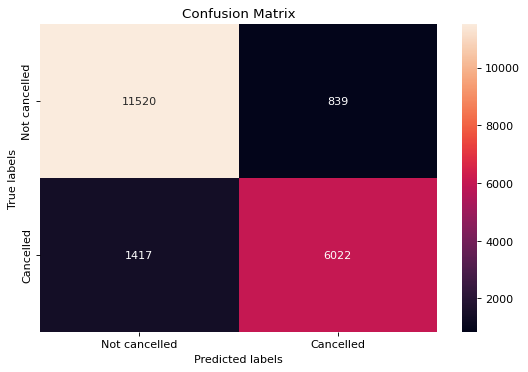

{'accuracy': 0.8860490958682695, 'null_accuracy': 0.6242549752500253, 'f1_score': 0.8422377622377624, 'confusion_matrix': array([[11520,   839],
       [ 1417,  6022]]), 'savings': 602200, 'losses': 83900}


In [ ]:
Scaler = preprocessing.StandardScaler()
RF_Model = RandomForestClassifier()


RF_pipe = make_pipeline(
    Scaler,
    RF_Model
)

param_grid = {
    "randomforestclassifier__n_estimators": np.linspace(10, 200, 5).astype(int),
}

predictor = GridSearchCV(RF_pipe, param_grid, scoring="accuracy")
predictor.fit(X_train, y_train)

model = predictor.best_estimator_

print(evaluate_model(model, X_val, y_val, plots=True))

**Ada boost classifier**

This model was very good at not predicting a cancellation when there wasn't one but its f1 and accuracy scores are lower than that of the random forest classifier which, ultimately, is why we chose not to use it.

In [ ]:
#from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Scaler = preprocessing.StandardScaler()
# RF_Model = RandomForestClassifier()
# AB_Classifier = AdaBoostClassifier(RF_Model)

# ABC_pipe = make_pipeline(
#     Scaler,
#     AB_Classifier
# )

# model = ABC_pipe.fit(X_train, y_train)
# print(evaluate_model(model, X_val, y_val, plots=True))

In [ ]:
features = np.column_stack((X.columns, model.steps[-1][1].feature_importances_))
print(features[features[:, 1].argsort()][::-1])

[['lead_time' 0.10371961673043682]
 ['deposit_type_Non_Refund' 0.08028432701519442]
 ['country_PRT' 0.07412485331643284]
 ['deposit_type_No_Deposit' 0.06542858410335223]
 ['adr' 0.06273255948551626]
 ['total_of_special_requests' 0.05323111255897155]
 ['arrival_date_day_of_month_sin' 0.035954046761578234]
 ['arrival_date_week_number' 0.03590999880646891]
 ['arrival_date_day_of_month' 0.03518806910032726]
 ['arrival_date_day_of_month_cos' 0.0318597795557867]
 ['previous_cancellations' 0.030162408201625097]
 ['length_of_stay' 0.02902660204493874]
 ['was_room_changed' 0.0262691894223646]
 ['stays_in_week_nights' 0.025150200680110806]
 ['agent_9.0' 0.02465492368626922]
 ['required_car_parking_spaces' 0.02099649931550242]
 ['arrival_date_month' 0.019612904530261044]
 ['booking_changes' 0.017372642294620055]
 ['market_segment_Online_TA' 0.017249761599244223]
 ['arrival_date_month_cos' 0.016866511342933252]
 ['arrival_date_month_sin' 0.016772810251414007]
 ['stays_in_weekend_nights' 0.01672455

## 4. Discussion & Conclusions


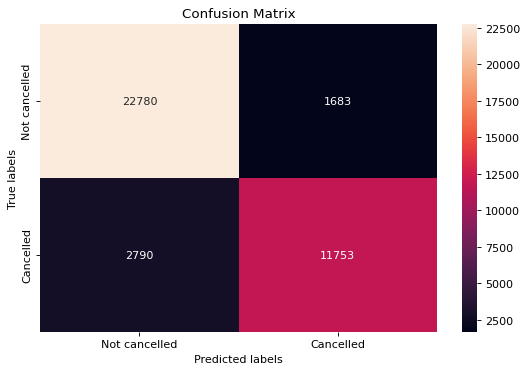

{'accuracy': 0.8853253345639133, 'null_accuracy': 0.6271599241142388, 'f1_score': 0.8401300975731799, 'confusion_matrix': array([[22780,  1683],
       [ 2790, 11753]]), 'savings': 1175300, 'losses': 168300}


In [ ]:
print(evaluate_model(model, X_test, y_test, plots=True))

The final model is a Random Forest Classifier. We believe that this model is the best based on several of its performance characteristics. We can clearly see that it has a high f1 score of 0.84. On a data set of this size and for data based on random chance due to human nature, this is a very high score and bodes well as a classifier. In our opinion, if a model is going to make a mistake there is one type of mistake that is better than the other in the context of hotel bookings. That is to say, it is better that the model tells us someone won't cancel when they actually do over saying that they will cancel but they don't. This is because if we assume someone will cancel and they don't and the hotel is full, there is now nowhere to put them which is not only extremely poor service from a hotel but could even lead to excess compensation being paid as well as refunding the customer. However, if we assume they won't cancel and they do, all we have is an empty room and the cost of that persons stay lost. So looking at the confusion matrix for our model displayed in the evaluation of the model on the test data above, we can see the number of false predictions that a person will cancel is significantly lower than the number of false predictions that a person won't cancel.

We can look closer at our model and see certain features have a significant impact on whether a booking is going to be cancelled or not. It seems that a booking is more likely to be cancelled if there is a bigger gap between the date of the booking and the arrival date. A non refundable deposit leads to less cancellations, as we would expect. Furthermore, if there is no deposit made then the bookings are more likely to be cancelled. As a last observation, we also see a higher average rate of a room leading to booking cancellations. Aside from predicting whether a person can cancel, we can thus use the model to advise some procedures taken by the hotel to deter guests from cancelling. So we suggest placing a limit on how far in advance bookings can be taken as well as enforcing the use of non refundable deposits. 

In [ ]:
print(f"The mean lead time is {np.mean(engineered_df['lead_time'])}")

The mean lead time is 104.75782803286039


Above we can see the mean lead time is 104 days. So limiting the amount of time a guest can book in advance to around 100 seems like a good way of minimising cancellations.



<function matplotlib.pyplot.show(close=None, block=None)>

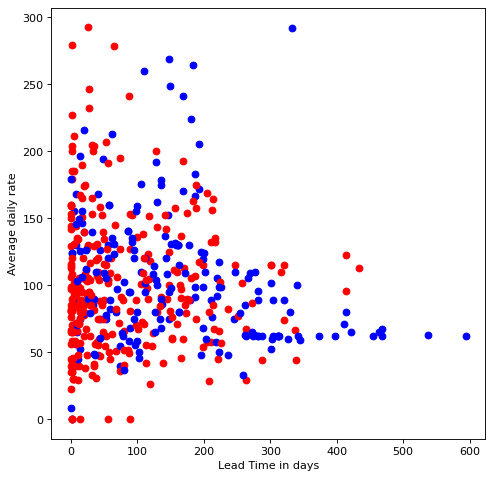

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

for i in range(500):
    point = np.random.randint(0, X_test.shape[0])
    if y_test.iloc[point] == 0:
      ax.scatter(X_test['lead_time'].iloc[point], X_test['adr'].iloc[point], c = 'r')
    else:
      ax.scatter(X_test['lead_time'].iloc[point], X_test['adr'].iloc[point], c = 'b')

ax.set_xlabel('Lead Time in days')
ax.set_ylabel('Average daily rate')
plt.show

Looking at the above plot, however, we can see our blue points, indicating a booking was cancelled are the majority of points higher than approximately 250 days so this is likely to be a better choice of cut off.

Back to the problem of predicting cancellations though, we can now discuss the cost benefits of using the model. The function `evaluate_model` has a feature that tells us how much a hotel saves and loses depending on the cost of room. Let's say that a room costs £100 a night. As a pessimistic approach, we say that if a room cancellation is wrongly predicted, the hotel loses £100. In reality, if we predict a cancellation that doesn't occur, if there is spare rooms, the hotel loses nothing. However, if we predict a guest won't cancel but they do, the hotel loses the cost of the room minus the non refundable deposit. So we assume there is no deposit to account for the "worst case scenario". Then looking at the model applied to the testing set above, we can see that the hotel, in this situation, saves £1091300 for 39006 bookings. That's approximately £30 per booking which is great.